## Data processing and plotting for manuscript: Cave airflow patterns control calcite dissolution rates within a cave stream: Blowing Springs Cave, Arkansas, USA

In [1]:
%pylab inline

#Import from standard scientific computing and plotting packages
from pandas import read_csv, concat, DataFrame, Series, Timedelta
from scipy.optimize import curve_fit
from scipy.stats import spearmanr,linregress
import seaborn as sns

#Imports from Olm. A copy of the needed components of Olm is included in this
#repository, so that this code should work without installation of Olm. However,
#an updated version of the Olm package can be found on Github at:
#
#  https://github.com/CovingtonResearchGroup/olm
#####################################################
from olm.loggers.CampbellToolkit import read_dat
from olm.calcite import solutionFromCaPCO2, pwpFromSolution, pwp_to_mm_yr, palmerFromSolution#Relaxed
from olm.general import mgL_to_molL, CaFromCond, condTo25
from olm.USGS.DataRetrieval import GetDailyDischargeRecord



Populating the interactive namespace from numpy and matplotlib


### Read Blowing Springs data and clean up bad values.

In [2]:
######################
## csv file was generated by initial pre-processing script that concatenates data
## from all loggers on site and resamples at hourly frequency.
######################
df = read_csv('Blowing-Springs-master-data-interpolated.csv', parse_dates=True, index_col=0)


##############
#Clean up data
##############

#Fix period where temp was recorded as F (convert to C)
where_f = df.Temp_Baro_outside>40.
df.Temp_Baro_outside[where_f]= (df.Temp_Baro_outside[where_f]-32.)*5./9.
where_f = df.Temp_outside>40.
df.Temp_outside[where_f]= (df.Temp_outside[where_f]-32.)*5./9.
where_f = df.Temp_BS4_Cond>17.
df.Temp_BS4_Cond[where_f] = (df.Temp_BS4_Cond[where_f] - 32.)*(5./9.)



df.CO2_Water['10-13-2015':'11-25-2015'] = np.nan
#Corrected for different sensor, switched from 2% to 10%
df.CO2_Water['11-25-2015':'12-25-2015'] = 5.*df.CO2_Water['11-25-2015':'12-25-2015']
df.CO2_Water['1-1-2016':'2-22-2016'] = np.nan
df.CO2_Water[df.CO2_Water<500./1000000.] = np.nan
df.CO2_Water[df.CO2_Water<300] = np.nan
df.CO2_Air[df.CO2_Air<300] = np.nan

#Filter out low conductivity values (which are bad)
df.Cond_BS4_Cond[df.Cond_BS4_Cond<40] = np.nan
#Remove low spikes
df.Temp_BS4_Cond[df.Temp_BS4_Cond<10] = np.nan

#Correct cond to 25 C
Cond_temp_corrected = condTo25(df.Cond_BS4_Cond, df.Temp_BS4_Cond)


### Read in USGS discharge data and estimate Blowing Springs discharge

In [3]:
######
## Commented out code automatically retrives data from USGS NWIS. 
## Here is it saved as .csv, so this isn't needed anymore.
#####
#sc = GetDailyDischargeRecord('07188838', str(df.index[0])[:10], str(df.index[-1])[:10])
#sc.to_csv('Little-Sugar-Creek-discharge.csv')

sc = read_csv('Little-Sugar-Creek-discharge.csv', index_col=0, parse_dates=True)
cms_per_cfs = 0.0283
cms_to_ls = 1000.
#Estimate Blowing Springs discharge based on relationship from Knierim et al. (2015)
bs_q_est = (sc.discharge*cms_per_cfs*0.0066 + 0.0023) * cms_to_ls

### Plot SpC vs. Q and fit polynomial (Fig 3)

In [6]:
p, residuals, rank, singular_values, rcond=polyfit(log10(qspc.q), qspc.cond,4, full='True')

In [9]:
sqrt(residuals/len(qspc.q))

array([14.92260871])

Polynomial coeffs. from high to low order: [ -25.4660138   218.88425894 -649.81759362  704.93541568   10.40892646]
RMSE =  14.9


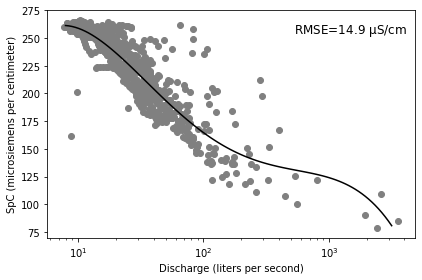

In [25]:
#Resample SpC on daily frequency
qspc = DataFrame({'q':bs_q_est.values, 'cond':Cond_temp_corrected.resample('d').mean().values}, index=bs_q_est.index)
#Get rid of NaNs (missing data)
qspc = qspc.dropna()
#Fit polynomial
pmod, residuals, rank, singular_values, rcond = polyfit(log10(qspc.q), qspc.cond,4, full=True)
pfit = poly1d(pmod)
print ("Polynomial coeffs. from high to low order:",pmod)

RMSE = sqrt(residuals/len(qspc.q))[0]
print("RMSE = ",str(RMSE)[:4])

figure()
semilogx(qspc.q,qspc.cond,'o',color='grey')
xfit = linspace(0.9,3.5,100)
plot(10**xfit,pfit(xfit),'k-', lw=1.5)
xlabel('Discharge (liters per second)')
ylabel('SpC (microsiemens per centimeter)')
ax = gca()
text(0.67,0.9, 'RMSE='+str(RMSE)[:4]+r' ${\rm \mu S/cm}$',transform=ax.transAxes, fontsize=12)
tight_layout()
savefig('Fig3.pdf')


### Create total time series plot (Fig 2)

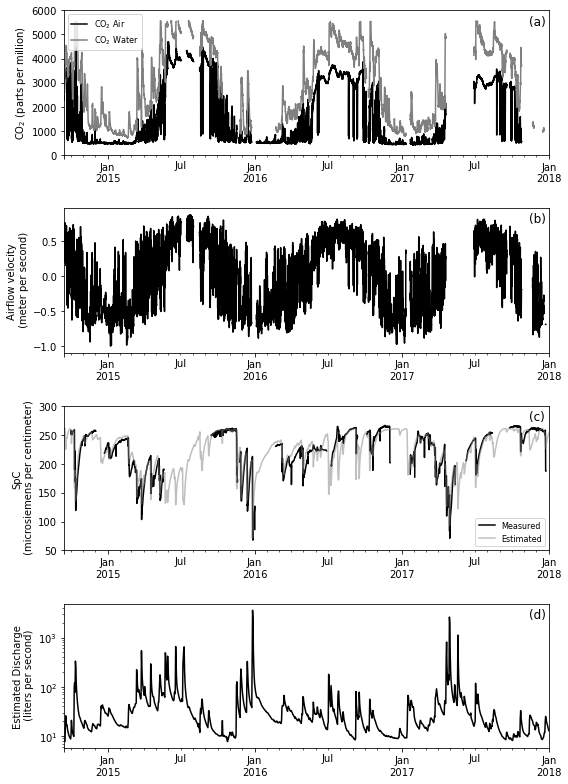

In [32]:
##Figure 2
figure(figsize=(8,11))
subplot(4,1,1)
df.CO2_Air.plot(color='black')
df.CO2_Water.plot(color='gray')
ylim([0,6000])
legend([r'${\rm CO_2}$ Air',r'${\rm CO_2}$ Water'],fontsize=8)
ax = gca()
text(0.96,0.9, '(a)',fontsize=12, transform=ax.transAxes)
ylabel(r'${\rm CO_2}$ (parts per million)')

subplot(4,1,2)
df.WindVelDir.plot(color='k')
ylabel('Airflow velocity\n (meter per second)')
ax = gca()
text(0.96,0.9, '(b)',fontsize=12, transform=ax.transAxes)
  
subplot(4,1,3)
Cond_temp_corrected.plot(color='k')
#Create estimated SpC timeseries
cond_est = DataFrame({'cond_est':pfit(log10(bs_q_est.values))}, index=bs_q_est.index)
cond_est.cond_est.plot(color='grey', alpha=0.5)
legend(['Measured','Estimated'],fontsize=8)
ylabel('SpC\n (microsiemens per centimeter)')
ylim([50,300])
ax = gca()
text(0.96,0.9, '(c)',fontsize=12, transform=ax.transAxes)


subplot(4,1,4)
bs_q_est.plot(color='k',logy=True)
ylabel('Estimated Discharge\n (liters per second)', fontsize=10)
ax = gca()
text(0.96,0.9, '(d)',fontsize=12, transform=ax.transAxes)


tight_layout()
savefig('Fig2.pdf')


### Chimney effect airflow (Fig 4)

R_opt= [0.15671934]
approximated diameter = 0.9521632653061223


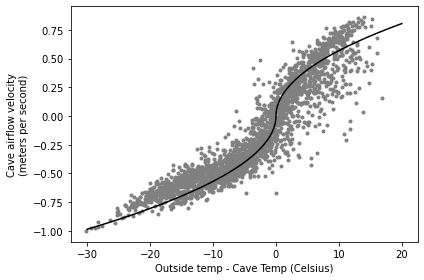

In [27]:
#Fig 4
T_cave = 15.
temp_diff = df.Temp_Baro_outside - T_cave

#Get rid of missing values for fit.
tmp_df = DataFrame({'diff':temp_diff.values,'wind':df.WindVelDir.values })
tmp_df = tmp_df.dropna()

#Define fitting function for chimney effect airflow
def chmny(diff, R):
    return sign(diff)*R*abs(diff)**0.5

#Find best fit
R_opt, p_cov = curve_fit(chmny, tmp_df['diff'].values[0:-1:5], tmp_df['wind'].values[0:-1:5], p0=1.1)
print ("R_opt=",R_opt)
figure()
#Plot temp diff vs. wind vel
scatter(temp_diff[0:-1:5], df.WindVelDir[0:-1:5], marker='.',color='grey')
xfit = linspace(-30,20, 500)
####
# best-fit value is R_opt=0.157
# However, this seems strongly influenced by scatter at positive Windvel.
# Least-squares fitting strongly penalizes outliers.
# Adjusted this to 0.18 to better fit the densest part of the data.
####
R_plot=0.18
yfit = chmny(xfit, R_plot)
plot(xfit,yfit, color='k', lw=1.5)
xlabel('Outside temp - Cave Temp (Celsius)')
ylabel('Cave airflow velocity\n(meters per second)')
tight_layout()
savefig('Fig4.pdf')

#Using value of
f=0.05
T_ext = 15.+273.
L=1000.
deltah = 25
g=9.8
print ("approximated diameter =",R_plot**2*f*L*T_ext/(2.*g*deltah))



### Zoomed figure of CO2-airflow interactions (Fig 5)

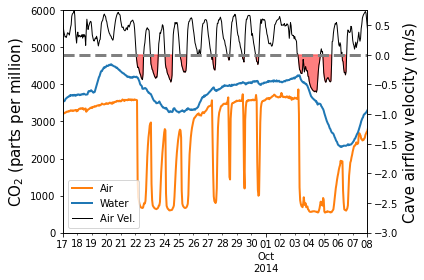

In [28]:
CO2_Water = df.CO2_Water
CO2_Air = df.CO2_Air
wv = df.WindVelDir
fig1, ax1 = subplots()
lns1 = CO2_Air.plot(axes=ax1, lw=2, color='C1')
lns2 = CO2_Water.plot(axes=ax1, lw=2, color='C0')
ax1.set_ylabel(r'${\rm CO_2}$ (parts per million)', fontsize=15)
ax1.set_ylim([0,6000])
ax1.set_xlim(['9/17/2014', '10/8/2014'])

ax2 = ax1.twinx()
lns3 = wv.plot(axes=ax2, lw=1, color='black')
legend(ax1.lines+ax2.lines, ['Air', 'Water','Air Vel.'])
ax2.fill_between(df.index,0, wv, where=(wv<=0), color='red', alpha=.5)
ax2.plot([391920.0, 392424.0],[0,0], '--', color='grey',lw=3)
ax2.get_xlim()
ax2.set_ylim([-3.,0.75])
ax2.set_ylabel('Cave airflow velocity (m/s)', fontsize=15)
ax2.set_xlim(['9/17/2014', '10/8/2014'])
tight_layout()

savefig('Fig5.pdf')#Wind-direction-and-CO2.png')
#show()

In [29]:
#############
### Read Ca-SpC data from Kneirim et al. (2017)
#############
kd = read_csv('Knierim-BS-Water-Chem-Data.csv', na_values=-9999)

m= 0.1750781049859214
b= -2.513275596618705
rmse= 5.840184045815814
rmspe= 0.22439541576555838
mean error = -0.17813827476737287
n= 109


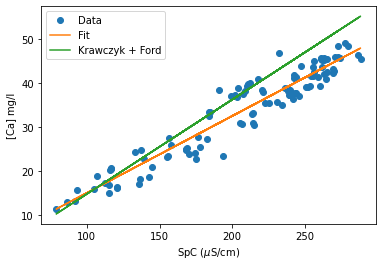

In [30]:
### Clean out bad values
good_ids = kd.Flag != 'E'
good_ids = logical_and(good_ids, ~kd.SpecCond.isnull()) 
good_ids = logical_and(good_ids, ~kd.Ca.isnull())
kdspc = kd.SpecCond[good_ids]
kdCa = kd.Ca[good_ids]
#Regress Ca vs. SpC 
m, b, r, p, err = linregress(kdspc,kdCa)
figure()
#Plot points and regression
plot(kdspc,kdCa, 'o')
plot(kdspc.values, m*kdspc.values +b, '-')
#Global relationship from Krawczyk and Ford (2006)
plot(kdspc.values, 0.4*(kdspc.values -31.5)/1.86, '-')
xlabel('SpC ($\mu$S/cm)')
ylabel('[Ca] mg/l')
legend(['Data','Fit','Krawczyk + Ford'])
print('m=',m)
print('b=', b)
print('rmse=',sqrt(mean(((kdCa - m*kdspc.values + b))**2.)))
print('rmspe=',sqrt(mean(((kdCa - m*kdspc.values + b)/kdCa)**2.)))
print('mean error =',mean((kdCa - m*kdspc.values + b)/kdCa))
print('n=',len(kdCa))


###  Calculate daily dissolution rates

In [33]:
#Create estimated Ca time series from fit above
Ca_mg_L = m*cond_est.cond_est+ b#Using data from Knierim et al. (2017) and estimated cond from Q

#Convert to mol/L
Ca = mgL_to_molL(Ca_mg_L,'Ca')

ppm_per_atm = 1e6
#Resample Ca and dissolve CO2 on daily frequency
diss_data = DataFrame({'Ca':Ca,'CO2':df.CO2_Water.resample('d').mean()/ppm_per_atm})
diss_data = diss_data.dropna()#get rid of rows with missing data

#Use Ca, CO2, and temp to create solution objects for each time stamp
solution_series = solutionFromCaPCO2(diss_data.Ca, diss_data.CO2,T_C=[15.]*len(diss_data.index))

# Calculate dissolution rates using solution objects
# Calculate PWP rates
diss_rate_pwp = pwpFromSolution(solution_series)
#Convert pwp rates to mm/yr
diss_rate_pwp_mmyr = pwp_to_mm_yr(diss_rate_pwp)
#Calculate Palmer rates
diss_rate_palmer_mmyr = palmerFromSolution(solution_series, impure=False)
########
## This will create some warnings, as some PCO2 values are out of range of Palmer's table
########

#Concatenate all dissolution rate data and data used to calculate rates
diss_data = concat({'palmer':diss_rate_palmer_mmyr, 'pwp':diss_rate_pwp_mmyr, 'Ca':Ca,'CO2':df.CO2_Water.resample('d').mean()/ppm_per_atm}, axis=1)

Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is 

Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is set to minimum from table.
Warning! Low PCO2 outside of interpolation range is 

### Plot dissolution rate time series (Fig 7)

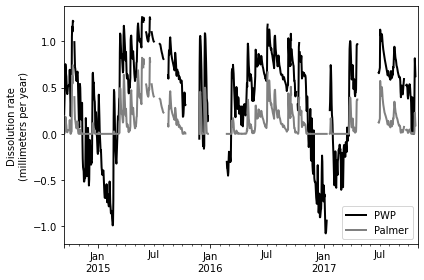

In [34]:
figure()
end_date = '11-1-2017' #Data mostly missing beyond this date
diss_data.pwp[:end_date].plot(color='k',lw=2)
diss_data.palmer[:end_date].plot(color='grey',lw=2)
legend(['PWP','Palmer'])
ylabel('Dissolution rate\n(millimeters per year)')
tight_layout()
savefig('Fig7.pdf')


### Calculate daily, weekly, and monthly averages of dissolution and possible controls

In [35]:
# Set period for analysis of dissolution rate variation and controls
start_date = '10-1-2014'
end_date = '1-1-2018'

#Average relevant variables on daily frequency
period = 'd'
smoothed_dissolution = diss_data.pwp[start_date:end_date].resample(period).mean()
smoothed_palmer = diss_data.palmer[start_date:end_date].resample(period).mean()
smoothed_cond = df.Cond_BS4_Cond[start_date:end_date].resample(period).mean()
smoothed_CO2 = df.CO2_Water[start_date:end_date].resample(period).mean()
smoothed_airv = df.WindVelDir[start_date:end_date].resample(period).mean()
smoothed_air_CO2 = df.CO2_Air[start_date:end_date].resample(period).mean()
smoothed_discharge = bs_q_est[start_date:end_date].resample(period).mean()

#Create DataFrame of daily averaged values
dr_ot_day = DataFrame({'diss':smoothed_dissolution, 
                       'palmer':smoothed_palmer,
                   'CO2':smoothed_CO2, 
                   'cond':smoothed_cond,
                   'airv':smoothed_airv,
                  'CO2_air':smoothed_air_CO2,
                      'discharge':smoothed_discharge})

#Drop NaNs
dr_ot_day = dr_ot_day.dropna()


#Average values over weekly frequency
period = '7d'
smoothed_dissolution = smoothed_dissolution[start_date:end_date].resample(period).mean()
smoothed_palmer = diss_data.palmer[start_date:end_date].resample(period).mean()
smoothed_cond = smoothed_cond[start_date:end_date].resample(period).mean()
smoothed_CO2 = smoothed_CO2[start_date:end_date].resample(period).mean()
smoothed_airv = smoothed_airv[start_date:end_date].resample(period).mean()
smoothed_air_CO2 = smoothed_air_CO2[start_date:end_date].resample(period).mean()
smoothed_discharge = bs_q_est[start_date:end_date].resample(period).mean()

#Store weekly averaged values in DataFrame
dr_ot_week = DataFrame({'diss':smoothed_dissolution, 
                        'palmer':smoothed_palmer,
                   'CO2':smoothed_CO2, 
                   'cond':smoothed_cond,
                   'airv':smoothed_airv,
                  'CO2_air':smoothed_air_CO2,
                      'discharge':smoothed_discharge})
dr_ot_week = dr_ot_week.dropna()

#monthly averages of values
period = '30d'
smoothed_dissolution = smoothed_dissolution[start_date:end_date].resample(period).mean()
smoothed_palmer = diss_data.palmer[start_date:end_date].resample(period).mean()
smoothed_cond = smoothed_cond[start_date:end_date].resample(period).mean()
smoothed_CO2 = smoothed_CO2[start_date:end_date].resample(period).mean()
smoothed_airv = smoothed_airv[start_date:end_date].resample(period).mean()
smoothed_air_CO2 = smoothed_air_CO2[start_date:end_date].resample(period).mean()
smoothed_discharge = bs_q_est[start_date:end_date].resample(period).mean()

#Store monthly averages in DataFrame
dr_ot_month = DataFrame({'diss':smoothed_dissolution, 
                         'palmer':smoothed_palmer,
                   'CO2':smoothed_CO2, 
                   'cond':smoothed_cond,
                   'airv':smoothed_airv,
                  'CO2_air':smoothed_air_CO2,
                      'discharge':smoothed_discharge})
dr_ot_month = dr_ot_month.dropna()



### Plot relationships between CO2 and airflow (Fig 6)

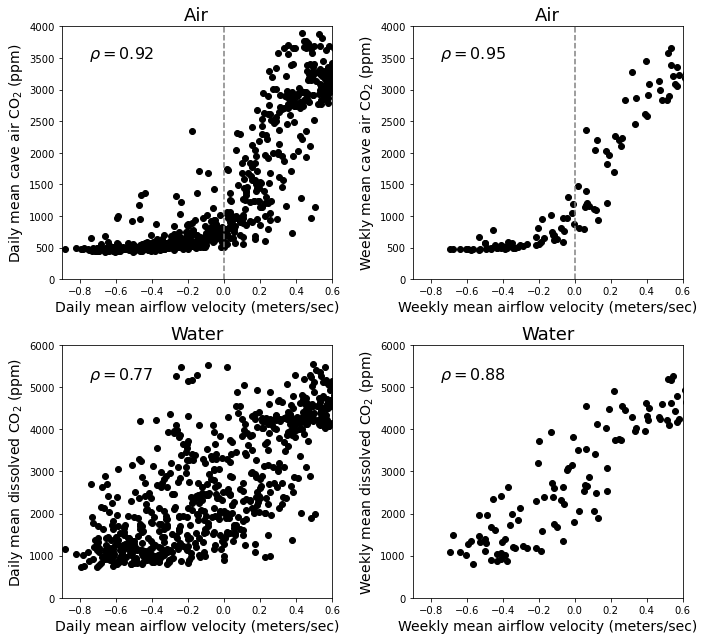

In [36]:

figure(figsize=(10,9))
subplot(2,2,1)
plot(dr_ot_day.airv, dr_ot_day.CO2_air, 'ok')
text(-.75,3500, r"$\rho=$"+str(spearmanr(dr_ot_day.airv, dr_ot_day.CO2_air)[0])[:4], fontsize=16, color='k')
plot([0,0],[0,4000],'--',color='grey')
xlabel('Daily mean airflow velocity (meters/sec)', fontsize=14)
ylabel(r'Daily mean cave air ${\rm CO_2}$ (ppm)', fontsize=14)
title('Air', fontsize=18)
xlim([-.9,.6])
ylim([0,4000])

subplot(2,2,2)
plot(dr_ot_week.airv, dr_ot_week.CO2_air, 'ok')
plot([0,0],[0,4000],'--',color='grey')
text(-.75,3500, r"$\rho=$"+str(spearmanr(dr_ot_week.airv, dr_ot_week.CO2_air)[0])[:4], fontsize=16, color='k')
xlabel('Weekly mean airflow velocity (meters/sec)', fontsize=14)
ylabel(r'Weekly mean cave air ${\rm CO_2}$ (ppm)', fontsize=14)
title('Air', fontsize=18)
xlim([-.9,.6])
ylim([0,4000])


subplot(2,2,3)
plot(dr_ot_day.airv, dr_ot_day.CO2, 'ok')
xlabel('Daily mean airflow velocity (meters/sec)', fontsize=14)
ylabel(r'Daily mean dissolved ${\rm CO_2}$ (ppm)', fontsize=14)
text(-.75,5200, r"$\rho=$"+str(spearmanr(dr_ot_day.airv, dr_ot_day.CO2)[0])[:4], fontsize=16, color='k')
title('Water', fontsize=18)
xlim([-.9,.6])
ylim([0,6000])


subplot(2,2,4)
plot(dr_ot_week.airv, dr_ot_week.CO2, 'ok')
title('Water', fontsize=18)
xlabel('Weekly mean airflow velocity (meters/sec)', fontsize=14)
ylabel(r'Weekly mean dissolved ${\rm CO_2}$ (ppm)', fontsize=14)
text(-.75,5200, r"$\rho=$"+str(spearmanr(dr_ot_week.airv, dr_ot_week.CO2)[0])[:4], fontsize=16, color='k')
xlim([-.9,.6])
ylim([0,6000])

tight_layout()
savefig('Fig6.pdf')

### Chemical controls of dissolution rate variation (Fig 8)

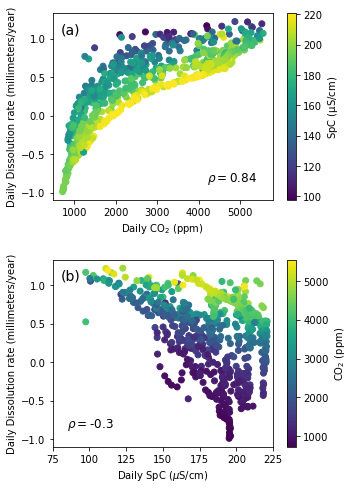

In [37]:
figure(figsize=(5,7))
subplot(2,1,1)
scatter(dr_ot_day.CO2, dr_ot_day.diss, c=dr_ot_day.cond)
xlabel(r'Daily ${\rm CO_2}$ (ppm)')
ylabel('Daily Dissolution rate (millimeters/year)')
rho,p = spearmanr(dr_ot_day.CO2, dr_ot_day.diss)
text(4200,-.85,r'$\rho=$'+str(rho)[0:4], fontsize=12)
ax = gca()
text(0.035,0.89,'(a)', transform=ax.transAxes, fontsize=14)
cb = colorbar()
cb.set_label(r'SpC (${\rm \mu S/cm})$')


subplot(2,1,2)
scatter(dr_ot_day.cond, dr_ot_day.diss, c=dr_ot_day.CO2)
xlabel('Daily SpC ($\mu$S/cm)')
ylabel('Daily Dissolution rate (millimeters/year)')
rho,p=spearmanr(dr_ot_day.cond, dr_ot_day.diss)
text(85,-.85,r'$\rho=$'+str(rho)[0:4], fontsize=12)
xlim([75.,225.])
ax = gca()
text(0.035,0.89,'(b)', transform=ax.transAxes, fontsize=14)
cb = colorbar()
cb.set_label(r'${\rm CO_2}$ (ppm)')

tight_layout()
savefig('Fig8.pdf')

### Physical drivers of dissolution rate variation (Fig 9)

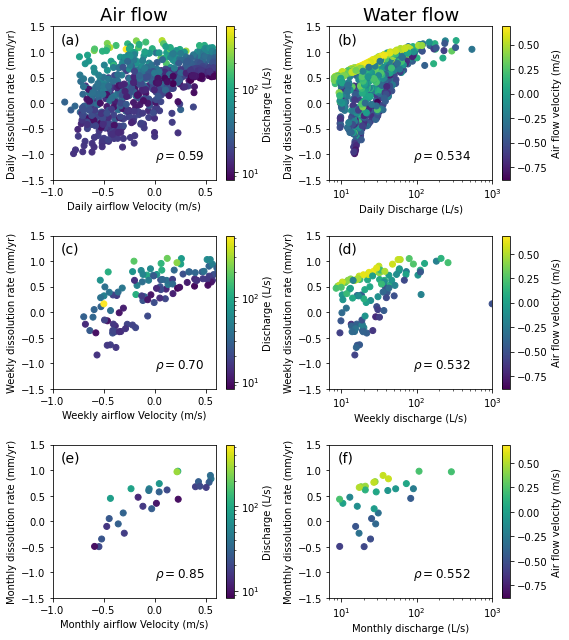

In [38]:
#Get max and min values for ranges on colorbars
qmax = max(dr_ot_day.discharge)
qmin = min(dr_ot_day.discharge)
airvmax = max(dr_ot_day.airv)
airvmin = min(dr_ot_day.airv)


figure(figsize=(8,9))

let_x=0.05
let_y=0.89

subplot(3,2,1)
scatter(dr_ot_day.airv, dr_ot_day.diss, c=dr_ot_day.discharge, vmin=qmin, vmax=qmax,norm=matplotlib.colors.LogNorm())
xlim([-1,.6])
ylim([-1.5,1.5])
title('Air flow',fontsize=18)
text(.0,-1.1, r"$\rho=$"+str(spearmanr(dr_ot_day.airv, dr_ot_day.diss)[0])[:4], fontsize=12)
xlabel('Daily airflow Velocity (m/s)')
ylabel('Daily dissolution rate (mm/yr)')
ax = gca()
text(let_x,let_y,'(a)', transform=ax.transAxes, fontsize=14)
cb = colorbar()
cb.set_label('Discharge (L/s)')

subplot(3,2,3)
scatter(dr_ot_week.airv, dr_ot_week.diss, c=dr_ot_week.discharge, vmin=qmin, vmax=qmax,norm=matplotlib.colors.LogNorm())
xlim([-1,.6])
ylim([-1.5,1.5])
text(.0,-1.1, r"$\rho=$"+str(spearmanr(dr_ot_week.airv, dr_ot_week.diss)[0])[:4], fontsize=12)
cb = colorbar()
cb.set_label('Discharge (L/s)')
xlabel('Weekly airflow Velocity (m/s)')
ylabel('Weekly dissolution rate (mm/yr)')
ax = gca()
text(let_x,let_y,'(c)', transform=ax.transAxes, fontsize=14)

subplot(3,2,5)
scatter(dr_ot_month.airv, dr_ot_month.diss, c=dr_ot_month.discharge, vmin=qmin, vmax=qmax,norm=matplotlib.colors.LogNorm())
text(.0,-1.1, r"$\rho=$"+str(spearmanr(dr_ot_month.airv, dr_ot_month.diss)[0])[:4], fontsize=12)
xlim([-1,.6])
ylim([-1.5,1.5])
xlabel('Monthly airflow Velocity (m/s)')
ylabel('Monthly dissolution rate (mm/yr)')
cb = colorbar()
cb.set_label('Discharge (L/s)')
ax = gca()
text(let_x,let_y,'(e)', transform=ax.transAxes, fontsize=14)

subplot(3,2,2)
scatter(dr_ot_day.discharge, dr_ot_day.diss, c=dr_ot_day.airv, vmax = airvmax, vmin=airvmin)
text(90,-1.1, r"$\rho=$"+str(spearmanr(dr_ot_day.discharge, dr_ot_day.diss)[0])[:5], fontsize=12)
ax = gca()
ax.set_xscale('log')
xlim([7,1000])
ylim([-1.5,1.5])
title('Water flow',fontsize=18)
xlabel('Daily Discharge (L/s)')
ylabel('Daily dissolution rate (mm/yr)')
cb = colorbar()
cb.set_label('Air flow velocity (m/s)')
ax = gca()
text(let_x,let_y,'(b)', transform=ax.transAxes, fontsize=14)

subplot(3,2,4)
scatter(dr_ot_week.discharge, dr_ot_week.diss, c=dr_ot_week.airv, vmax = airvmax, vmin=airvmin)
text(90,-1.1, r"$\rho=$"+str(spearmanr(dr_ot_week.discharge, dr_ot_week.diss)[0])[:5], fontsize=12)
xlim([7,1000])
ax = gca()
ax.set_xscale('log')
ylim([-1.5,1.5])
xlabel('Weekly discharge (L/s)')
ylabel('Weekly dissolution rate (mm/yr)')
cb = colorbar()
cb.set_label('Air flow velocity (m/s)')
ax = gca()
text(let_x,let_y,'(d)', transform=ax.transAxes, fontsize=14)

subplot(3,2,6)
scatter(dr_ot_month.discharge, dr_ot_month.diss, c=dr_ot_month.airv, vmax = airvmax, vmin=airvmin)
text(90,-1.1, r"$\rho=$"+str(spearmanr(dr_ot_month.discharge, dr_ot_month.diss)[0])[:5], fontsize=12)
xlim([7,1000])
ax = gca()
ax.set_xscale('log')
ylim([-1.5,1.5])
cb = colorbar()
cb.set_label('Air flow velocity (m/s)')
xlabel('Monthly discharge (L/s)')
ylabel('Monthly dissolution rate (mm/yr)')
ax = gca()
text(let_x,let_y,'(f)', transform=ax.transAxes, fontsize=14)

tight_layout()
savefig('Fig9.pdf')


### Dissolution rate pdf binned by airflow direction (Fig 10)

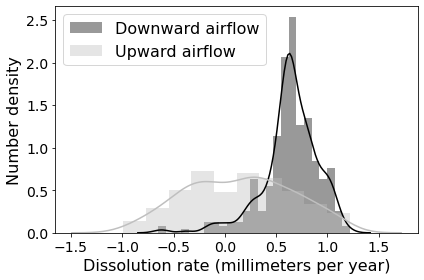

In [39]:
downward = dr_ot_day.airv>0
upward = dr_ot_day.airv<=0

figure()

sns.distplot(dr_ot_day.diss[downward].dropna(), color='0.0')
sns.distplot(dr_ot_day.diss[upward].dropna(), color='0.75')
ax = gca()
ax.tick_params('both', labelsize=14)
ylabel('Number density', fontsize=16)
xlabel('Dissolution rate (millimeters per year)', fontsize=16)
legend(['Downward airflow', 'Upward airflow'], fontsize=16)
tight_layout()
savefig('Fig10.pdf')


### Discharge vs. CO2 by airflow regime (Fig 11)

SpearmanrResult(correlation=0.04916388761367228, pvalue=0.3837433366447106)
SpearmanrResult(correlation=0.3073606331826764, pvalue=2.2149005840720302e-09)


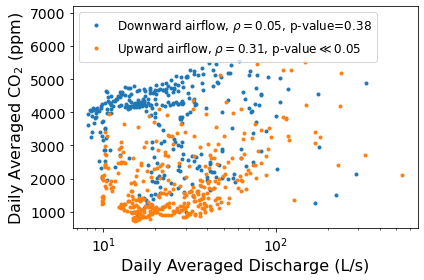

In [40]:
figure()
semilogx(dr_ot_day.discharge[downward], dr_ot_day.CO2[downward],'.',color='C0' )
semilogx(dr_ot_day.discharge[upward], dr_ot_day.CO2[upward],'.',color='C1' )

legend([r'Downward airflow, $\rho=0.05$, p-value=0.38',r'Upward airflow, $\rho=0.31$, p-value$\ll$0.05'], loc='upper left', fontsize=12)
xlabel('Daily Averaged Discharge (L/s)', fontsize=16)# (Sugar Creek)')
ylabel(r'Daily Averaged ${\rm CO_2}$ (ppm)', fontsize=16)
ylim([500,7200])

ax = gca()
ax.tick_params('both', labelsize=14)

tight_layout()
print(spearmanr(dr_ot_day.discharge[downward], dr_ot_day.CO2[downward]))
print(spearmanr(dr_ot_day.discharge[upward], dr_ot_day.CO2[upward]))
savefig('Fig11.pdf')


### Find storms

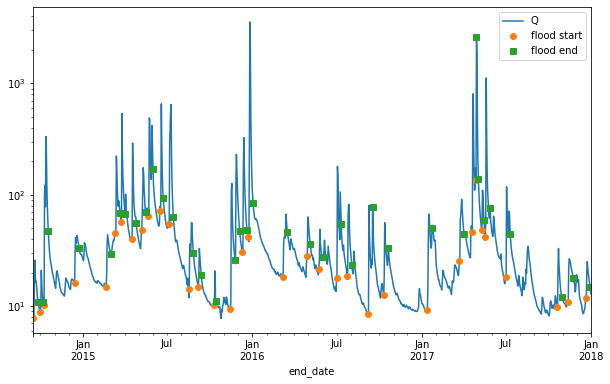

In [41]:
#Find storm dates

figure(figsize=(10,6))
bs_q_est.plot(logy=True)
#Look for factor of 2 increases in discharge
flood_start_days = []
#flood_dict = {}
flood_list = []
q_start = 0
i_start = 0
for i, day in enumerate(bs_q_est.index):
    if i>2 and q_start==0:
        #Check for factor of 2 increases over 1-2 days
        q_fact = max([bs_q_est.iloc[i]/bs_q_est.iloc[i-1],
                     bs_q_est.iloc[i]/bs_q_est.iloc[i-2]])
        if q_fact>2:
            i_start = i
            #if (last_flood<0) or (i-last_flood)>10:
            q_start = bs_q_est.iloc[i-2]
            flood_dict = {'start_date':bs_q_est.index[i-2],
                          'q_start':q_start}                           
                #flood_start_days.append(bs_q_est.index[i-2])
                
    else:
        if q_start>0:
            if bs_q_est.iloc[i]<q_start*1.3 or i-i_start>7:#Cut off floods at 7 days max:
                #Flood has ended
                flood_dict['end_date'] = bs_q_est.index[i]
                flood_dict['q_end'] = bs_q_est.iloc[i]
                flood_list.append(flood_dict)
                q_start=0
            
flood_df = DataFrame(flood_list)
flood_df.set_index(['start_date'], inplace=True)
flood_df.q_start.plot(style='o')
flood_ends = flood_df.set_index('end_date')
flood_ends.q_end.plot(style='s')
legend(['Q','flood start','flood end'])



In [52]:
#########################################################################
#Function to plot several parameters during a storm and return summary info
###########################################################################
def storm_fig(start,end, make_plots=True, n_cols = 1, this_col=0, save_fig=True, title_str=None):
    Ca_mg_L = m*Cond_temp_corrected[start:end] + b#Using data from Knierim et al. (2017) 
    Ca = mgL_to_molL(Ca_mg_L,'Ca')

    diss_storm = DataFrame({'Ca':Ca,'CO2':df.CO2_Water[start:end]/1000000.})#, 'Temp':df.Temp_BS4_Cond.resample('d').mean()}, axis=1)
    diss_storm = diss_storm.dropna()#get rid of rows with missing data
    #Use Ca, CO2, and temp to create solution objects for each time stamp
    solution_series = solutionFromCaPCO2(diss_storm.Ca, diss_storm.CO2,T_C=[15.]*len(diss_storm.index))#diss_data.Temp)
    #Calculate dissolution rates using solution objects
    diss_rate_pwp_storm = pwpFromSolution(solution_series)
    diss_rate_pwp_mmyr_storm = pwp_to_mm_yr(diss_rate_pwp_storm)

    #Calculate dissolution rates with average Ca value
    solution_series = solutionFromCaPCO2(Series(mean(diss_storm.Ca), index=diss_storm.index), diss_storm.CO2,T_C=[15.]*len(diss_storm.index))#diss_data.Temp)
    #Calculate dissolution rates using solution objects
    diss_rate_pwp_storm_avg_Ca = pwpFromSolution(solution_series)
    diss_rate_pwp_mmyr_storm_avg_Ca = pwp_to_mm_yr(diss_rate_pwp_storm_avg_Ca)

    #Calculate dissolution rates with average Ca value
    solution_series = solutionFromCaPCO2(diss_storm.Ca,Series(mean(diss_storm.CO2), index=diss_storm.index),T_C=[15.]*len(diss_storm.index))#diss_data.Temp)
    #Calculate dissolution rates using solution objects
    diss_rate_pwp_storm_avg_CO2 = pwpFromSolution(solution_series)
    diss_rate_pwp_mmyr_storm_avg_CO2 = pwp_to_mm_yr(diss_rate_pwp_storm_avg_CO2)
    
    #Calculate stats to return
    range_CO2 = (max(df.CO2_Water[start:end]) - min(df.CO2_Water[start:end]))/mean(df.CO2_Water[start:end])
    range_cond = (max(Cond_temp_corrected[start:end]) - min(Cond_temp_corrected[start:end]))/mean(Cond_temp_corrected[start:end])
    mean_airv = mean(df.WindVelDir[start:end])
    Q_mean = mean(bs_q_est[start:end])
    range_Q = (max(bs_q_est[start:end]) - min(bs_q_est[start:end]))/Q_mean
    if len(diss_rate_pwp_mmyr_storm)>10:
        range_pwp =  (max(diss_rate_pwp_mmyr_storm) - min(diss_rate_pwp_mmyr_storm))#no div by mean (see below)/mean(diss_rate_pwp_mmyr_storm)
        range_pwp_Ca =  (max(diss_rate_pwp_mmyr_storm_avg_CO2) - min(diss_rate_pwp_mmyr_storm_avg_CO2))# no mean because we have pos and neg values, this creates errors near zero/mean(diss_rate_pwp_mmyr_storm_avg_CO2)
        range_pwp_CO2 =  (max(diss_rate_pwp_mmyr_storm_avg_Ca) - min(diss_rate_pwp_mmyr_storm_avg_Ca))#/mean(diss_rate_pwp_mmyr_storm_avg_Ca)
    else:
        range_pwp = np.nan
        range_pwp_Ca = np.nan
        range_pwp_CO2 = np.nan
    
    if make_plots:
        if n_cols==1:
            figure(figsize=(8,11))
        subplot(4,n_cols,1+(n_cols-1)*this_col)
        df.CO2_Air[start:end].plot(color='black',x_compat=True)
        df.CO2_Water[start:end].plot(color='gray')
        legend([r'${\rm CO_2}$ Air',r'${\rm CO_2}$ Water'],fontsize=8)
        ylabel(r'${\rm CO_2}$ (ppm)')
        ylim([0,5000])
        if this_col>0:
            ylabel('')
            ax = gca()
            ax.set_yticklabels([''])
        if n_cols>1:
            xlabel('')
            ax = gca()
            ax.set_xticklabels([''])
            ax.tick_params(direction='in')
        if title_str != None:
            title(title_str)
        
        subplot(4,n_cols,3+(n_cols-1)*this_col)
        df.WindVelDir[start:end].plot(color='k',x_compat=True)
        ax = gca()
        xmin, xmax = ax.get_xlim()
        plot([xmin,xmax],[0,0],'--k',lw=2)
        ylabel('Airflow velocity (m/s)')
        ylim([-0.98,.98])
        if this_col>0:
            ylabel('')
            ax = gca()
            ax.set_yticklabels([''])
        if n_cols>1:
            xlabel('')
            ax = gca()
            ax.set_xticklabels([''])
            ax.tick_params(direction='in')
            
        subplot(4,n_cols,5+(n_cols-1)*this_col)
        Cond_temp_corrected[start:end].plot(color='k',x_compat=True)
        ylabel(r'SpC ($\mu$S/cm)')
        if this_col>0:
            ylabel('')
            ax = gca()
            ax.set_yticklabels([''])
        ylim([100,280])
        if n_cols>1:
            xlabel('')
            ax = gca()
            ax.set_xticklabels([''])
            ax.tick_params(direction='in')
            
        subplot(4,n_cols,7+(n_cols-1)*this_col)
        if len(diss_rate_pwp_mmyr_storm)>10:
            diss_rate_pwp_mmyr_storm.plot(color='k')#,x_compat=True)
            ylabel('Estimated Dissolution rate (mm/yr)', fontsize=10)
            ylim([-.5,1.45])
            if this_col>0:
                ylabel('')
                ax = gca()
                ax.set_yticklabels([''])
            if n_cols>0:
                ax = gca()
                ax.tick_params(axis='both',direction='in')

        tight_layout()
        if save_fig:
            savefig('./flood_plots/'+str(start)[:10]+'.png')
    
    return range_CO2, range_cond, mean_airv, Q_mean, range_Q, range_pwp, range_pwp_Ca, range_pwp_CO2

### Example storms (Fig 12)

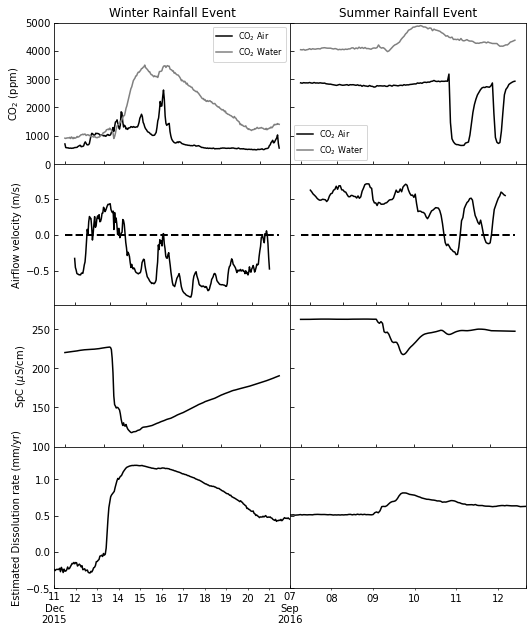

In [53]:

figure(figsize=(7.5,9))
storm_fig('2015-12-11', '2015-12-21',n_cols=2, this_col=0, make_plots=True, save_fig=False, title_str='Winter Rainfall Event')
storm_fig('2016-09-07', '2016-09-12',n_cols=2, this_col=1 ,make_plots=True,save_fig=False, title_str='Summer Rainfall Event')
subplots_adjust(wspace=0,hspace=0)
savefig('Fig12.pdf')


Max winter Q= 327.29720000000003
Min winter Q= 30.317
Max summer Q= 80.37404
Min summer Q= 8.407706000000001


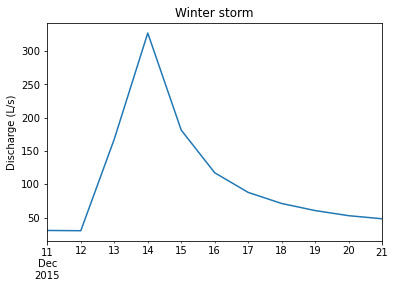

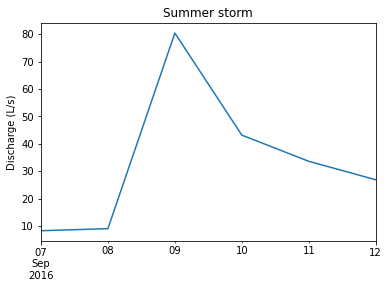

In [44]:
figure()
title('Winter storm')
bs_q_est['2015-12-11':'2015-12-21'].plot()
ylabel('Discharge (L/s)')
print("Max winter Q=",max(bs_q_est['2015-12-11':'2015-12-21']))
print("Min winter Q=",min(bs_q_est['2015-12-11':'2015-12-21']))

figure()
title('Summer storm')
bs_q_est['2016-09-07':'2016-09-12'].plot()
ylabel('Discharge (L/s)')
print("Max summer Q=",max(bs_q_est['2016-09-07':'2016-09-12']))
print("Min summer Q=",min(bs_q_est['2016-09-07':'2016-09-12']))


In [45]:
######################################
## Create dataframe of flood attributes
#######################################
months = []
CO2_ranges = []
Cond_ranges = []
mean_airvs = []
Q_means = []
Q_ranges = []
pwp_ranges = []
pwp_Ca_ranges = []
pwp_CO2_ranges = []
for start_date, end_date in zip(flood_df.index,flood_df.end_date):
    range_CO2, range_cond, airv, Q_mean, range_Q, range_pwp, range_pwp_Ca, range_pwp_CO2 = storm_fig(start_date,end_date,make_plots=False)
    months.append(start_date.month)
    CO2_ranges.append(range_CO2)
    Cond_ranges.append(range_cond)
    mean_airvs.append(airv)
    Q_means.append(Q_mean)
    Q_ranges.append(range_Q)
    pwp_ranges.append(range_pwp)
    pwp_Ca_ranges.append(range_pwp_Ca)
    pwp_CO2_ranges.append(range_pwp_CO2)
flood_descriptions = DataFrame({'months':months, 'CO2_range':CO2_ranges, 
                                'Cond_range':Cond_ranges, 'airv':mean_airvs, 'Q_mean':Q_means,
                                'Q_range':Q_ranges, 'pwp_range':pwp_ranges,
                                'pwp_Ca_range':pwp_Ca_ranges, 'pwp_CO2_range':pwp_CO2_ranges
                               }, index=flood_df.index)

In [46]:
###############
### Manually examined flood records and categorized by data quality and completeness 
################################3
flood_descriptions.dropna(inplace=True)
flood_notes = {}
flood_notes['2014-10-08']='over range CO2'
flood_notes['2015-02-20'] = 'good'
flood_notes['2015-03-12'] = 'good'
flood_notes['2015-03-24'] = 'good'
flood_notes['2015-04-16'] = 'good'
flood_notes['2015-05-08'] = 'good'
flood_notes['2015-10-11'] = 'low var, local storm?'
flood_notes['2015-11-25'] = "good, but doesn't appear in filtered list"
flood_notes['2015-12-11'] = 'good'
flood_notes['2015-12-24'] = 'airflow and CO2 look very suspicious'
flood_notes['2016-03-07'] = 'good'
flood_notes['2016-04-28'] = 'good'
flood_notes['2016-05-24'] = 'good'
flood_notes['2016-07-24'] = 'good, though actual event is on 27 or 28'
flood_notes['2016-09-07'] = 'good, though real even on Sept 9'
flood_notes['2016-10-11'] = 'CO2 maxes out'
flood_notes['2017-03-23'] = 'good'
flood_notes['2017-04-19'] = 'airv and CO2 record incomplete'
flood_notes['2017-07-01'] = 'OK. CO2 maxes but looks fairly flat'
flood_notes['2017-10-20'] = 'good, but event on 10/22'


#### Numerical descriptors for data quality 
## 1=good
## 0=ok
## -1=bad
flood_descriptions['good'] = [0,1,1,1,1,1,-1,1,-1,1,1,1,1,1,0,1,-1,0,1]  
flood_descriptions

,months,CO2_range,Cond_range,airv,Q_mean,Q_range,pwp_range,pwp_Ca_range,pwp_CO2_range,good
start_date,,,,,,,,,,
2014-10-08,10,0.504681,0.742660,0.008571,109.226456,2.957489,0.853462,0.677390,0.214667,0
2015-02-20,2,0.909988,0.336519,-0.619195,32.004812,0.904580,1.578220,0.793664,0.659646,1
2015-03-12,3,1.232147,0.370777,-0.152817,98.033240,1.808103,0.727912,0.343690,0.511015,1
2015-03-24,3,1.099478,0.485084,-0.131951,147.577484,3.264086,0.520635,0.331458,0.404497,1
2015-04-16,4,0.770398,0.365184,0.027680,96.657860,2.604852,0.604923,0.399326,0.295098,1
2015-05-08,5,0.666427,0.439731,0.227969,93.907100,1.342566,0.541237,0.327681,0.221222,1
2015-10-11,10,0.293000,0.036189,0.204047,13.642216,0.768083,0.213009,0.070983,0.213486,-1
2015-12-11,12,1.285574,0.650360,-0.379026,106.896800,2.778195,1.484889,0.769218,0.584390,1
2015-12-24,12,0.087402,1.046315,-0.640371,694.897220,5.082511,0.108651,0.056132,0.065319,-1


### Flood variability correlations (Fig 13)

rho airv+pwp= -0.8516483516483516   p= 0.00022021941625366222
rho Q+pwp= -0.04395604395604395   p= 0.8866190227890784


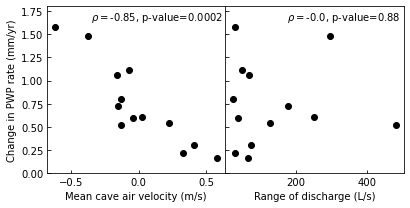

In [47]:
figure(figsize=(6,3))

subplot(1,2,1)
plot(flood_descriptions.airv[flood_descriptions.good==1], 
     flood_descriptions.pwp_range[flood_descriptions.good==1], 'ko')
ylabel('Change in PWP rate (mm/yr)')
xlabel('Mean cave air velocity (m/s)')
ax = gca()
#ax.set_xticklabels([''])
ax.tick_params(direction='in')
r, p = spearmanr(flood_descriptions.airv[flood_descriptions.good==1], 
     flood_descriptions.pwp_range[flood_descriptions.good==1])
text(-.35,1.65,r'$\rho=$' + str(r)[0:5] + ', p-value='+str(p)[:6] )
print('rho airv+pwp=',r,'  p=',p)
ylim([0.0,1.8])


subplot(1,2,2)
plot(flood_descriptions.Q_range[flood_descriptions.good==1]*flood_descriptions.Q_mean[flood_descriptions.good==1], 
     flood_descriptions.pwp_range[flood_descriptions.good==1], 'ko')
xlabel('Range of discharge (L/s)')
ax = gca()
ax.set_yticklabels([''])
ax.tick_params(direction='in')
r, p = spearmanr(flood_descriptions.Q_range[flood_descriptions.good==1]*flood_descriptions.Q_mean[flood_descriptions.good==1], 
     flood_descriptions.pwp_range[flood_descriptions.good==1])
text(175,1.65,r'$\rho=$' + str(r)[0:4]+ ', p-value='+str(p)[:4] )
#text(295,0.2,r'not significant')
print('rho Q+pwp=',r,'  p=',p)
ylim([0.,1.8])

tight_layout()
subplots_adjust(wspace=0)
savefig('Fig13.pdf')